<a href="https://colab.research.google.com/github/kushal-g/FlightDelayPredictor/blob/master/More%20models/CleaningProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
import pandas as pd

In [0]:
from multiprocessing import Pool

In [0]:
import matplotlib as plt

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
df = pd.read_csv("flights.csv",dtype={"MONTH":object,"DAY_OF_WEEK":object,"ORIGIN_AIRPORT":object,"DESTINATION_AIRPORT":object}).drop(["CANCELLATION_REASON","AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY"],axis=1)
df.dropna(inplace=True)
df =df[(df["ARRIVAL_DELAY"]<=200) & (df["ARRIVAL_DELAY"]>=-35)]
df =df[(df["DEPARTURE_DELAY"]<=150) & (df["DEPARTURE_DELAY"]>=-15)]
df = df.sample(frac=0.2,random_state=42)
df = df.reset_index().drop(["index"],axis=1)

In [8]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,5,20,3,F9,770,N208FR,LAS,DEN,1050,1104.0,14.0,24.0,1128.0,110.0,108.0,79.0,628,1347.0,5.0,1340,1352.0,12.0,0,0
1,2015,10,18,7,MQ,3342,N697MQ,11980,11298,1407,1356.0,-11.0,5.0,1401.0,111.0,93.0,81.0,561,1522.0,7.0,1558,1529.0,-29.0,0,0
2,2015,12,27,7,DL,2184,N990AT,SDF,ATL,1710,1717.0,7.0,25.0,1742.0,95.0,92.0,60.0,321,1842.0,7.0,1845,1849.0,4.0,0,0
3,2015,2,9,1,NK,561,N529NK,DEN,LAS,1130,1126.0,-4.0,14.0,1140.0,115.0,121.0,103.0,628,1223.0,4.0,1225,1227.0,2.0,0,0
4,2015,11,9,1,HA,211,N477HA,OGG,LIH,1129,1126.0,-3.0,10.0,1136.0,47.0,49.0,34.0,201,1210.0,5.0,1216,1215.0,-1.0,0,0


In [0]:
df.drop(["YEAR","DAY","FLIGHT_NUMBER","DEPARTURE_TIME","ARRIVAL_TIME"],axis=1,inplace=True)

In [10]:
df.head()

,MONTH,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,5,3,F9,N208FR,LAS,DEN,1050,14.0,24.0,1128.0,110.0,108.0,79.0,628,1347.0,5.0,1340,12.0,0,0
1,10,7,MQ,N697MQ,11980,11298,1407,-11.0,5.0,1401.0,111.0,93.0,81.0,561,1522.0,7.0,1558,-29.0,0,0
2,12,7,DL,N990AT,SDF,ATL,1710,7.0,25.0,1742.0,95.0,92.0,60.0,321,1842.0,7.0,1845,4.0,0,0
3,2,1,NK,N529NK,DEN,LAS,1130,-4.0,14.0,1140.0,115.0,121.0,103.0,628,1223.0,4.0,1225,2.0,0,0
4,11,1,HA,N477HA,OGG,LIH,1129,-3.0,10.0,1136.0,47.0,49.0,34.0,201,1210.0,5.0,1216,-1.0,0,0


In [0]:
df.drop(["TAXI_OUT","WHEELS_OFF","ELAPSED_TIME","AIR_TIME","WHEELS_ON","TAXI_IN"],axis=1,inplace=True)

In [0]:
def interval3(timeList):
  list =[]
  count = 0
  for time in timeList:
    if(time<200):
      count=count+1
      list.append("[0000,0200)")
    elif(time<400):
      list.append("[0200,0400)")
    elif(time<600):
      list.append("[0400,0600)")
    elif(time<800):
      list.append("[0600,0800)")
    elif(time<1000):
      list.append("[0800,1000)")
    elif(time<1200):
      list.append("[1000,1200)")
    elif(time<1400):
      list.append("[1200,1400)")
    elif(time<1600):
      list.append("[1400,1600)")
    elif(time<1800):
      list.append("[1600,1800)")
    elif(time<2000):
      list.append("[1800,2000)")
    elif(time<2200):
      list.append("[2000,2200)")
    elif(time<=2359):
      list.append("[2200,2359]")
  
  return list

In [0]:
scheduledDeparture = interval3(df["SCHEDULED_DEPARTURE"])

In [0]:
scheduledDeparture = pd.Series(scheduledDeparture,name="SCHEDULED_DEPARTURE_BINNED")

In [0]:
df = pd.concat([df,scheduledDeparture],axis=1)

In [0]:
scheduledArrival = pd.Series(interval3(df["SCHEDULED_ARRIVAL"]),name="SCHEDULED_ARRIVAL_BINNED")

In [0]:
df = pd.concat([df,scheduledArrival],axis=1)

In [18]:
df.head()

,MONTH,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DIVERTED,CANCELLED,SCHEDULED_DEPARTURE_BINNED,SCHEDULED_ARRIVAL_BINNED
0,5,3,F9,N208FR,LAS,DEN,1050,14.0,110.0,628,1340,12.0,0,0,"[1000,1200)","[1200,1400)"
1,10,7,MQ,N697MQ,11980,11298,1407,-11.0,111.0,561,1558,-29.0,0,0,"[1400,1600)","[1400,1600)"
2,12,7,DL,N990AT,SDF,ATL,1710,7.0,95.0,321,1845,4.0,0,0,"[1600,1800)","[1800,2000)"
3,2,1,NK,N529NK,DEN,LAS,1130,-4.0,115.0,628,1225,2.0,0,0,"[1000,1200)","[1200,1400)"
4,11,1,HA,N477HA,OGG,LIH,1129,-3.0,47.0,201,1216,-1.0,0,0,"[1000,1200)","[1200,1400)"


In [0]:
df.drop(["SCHEDULED_DEPARTURE","SCHEDULED_ARRIVAL"],axis=1,inplace=True)

In [20]:
df.head()

,MONTH,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,SCHEDULED_DEPARTURE_BINNED,SCHEDULED_ARRIVAL_BINNED
0,5,3,F9,N208FR,LAS,DEN,14.0,110.0,628,12.0,0,0,"[1000,1200)","[1200,1400)"
1,10,7,MQ,N697MQ,11980,11298,-11.0,111.0,561,-29.0,0,0,"[1400,1600)","[1400,1600)"
2,12,7,DL,N990AT,SDF,ATL,7.0,95.0,321,4.0,0,0,"[1600,1800)","[1800,2000)"
3,2,1,NK,N529NK,DEN,LAS,-4.0,115.0,628,2.0,0,0,"[1000,1200)","[1200,1400)"
4,11,1,HA,N477HA,OGG,LIH,-3.0,47.0,201,-1.0,0,0,"[1000,1200)","[1200,1400)"


In [21]:
pip install geopandas

In [0]:
import geopandas

In [0]:
from shapely.geometry import Point, Polygon

In [0]:
usa = geopandas.read_file("states.shp")

In [0]:
airports = geopandas.read_file("airports.shp")

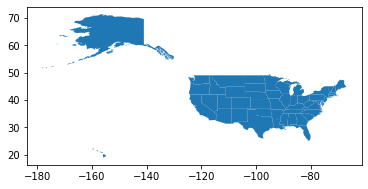

In [26]:
usa.plot()

In [27]:
airports.tail()

,geometry
1875,POINT (-164.68566 60.47032)
1876,POINT (-162.52483 60.87202)
1877,POINT (-164.49107 62.78519)
1878,POINT (-168.09919 65.62394)
1879,POINT (-65.30432 18.31329)


In [0]:
airport_total_arrival_delay = df.groupby("ORIGIN_AIRPORT").ARRIVAL_DELAY.apply(lambda delays : delays.mean())

In [0]:
airport_total_arrival_delay.sort_values(ascending=False,inplace=True)

In [0]:
airport_arrival_matrix = np.array(airport_total_arrival_delay.index[:-4]).reshape(24,26)

In [31]:
airport_arrival_matrix[-1]

array(['11274', '13061', '14674', '11525', '11049', '13502', 'DIK',
       '12511', '14960', '12335', '11413', '10779', '13290', '11980',
       '15048', '10136', 'HYA', '11067', '11648', '12343', '13127',
       '14487', '10747', '14543', '10155', '11867'], dtype=object)

In [32]:
leftoverAirports = airport_total_arrival_delay.index[-4:]
leftoverAirports

Index(['12094', '10268', 'CNY', '11503'], dtype='object', name='ORIGIN_AIRPORT')

In [0]:
airport_arrival_matrix = np.append(airport_arrival_matrix,np.zeros((len(airport_arrival_matrix),4)),axis=1)

In [0]:
airport_arrival_matrix[-1][-4:] = leftoverAirports

In [35]:
airport_arrival_matrix[-1]

array(['11274', '13061', '14674', '11525', '11049', '13502', 'DIK',
       '12511', '14960', '12335', '11413', '10779', '13290', '11980',
       '15048', '10136', 'HYA', '11067', '11648', '12343', '13127',
       '14487', '10747', '14543', '10155', '11867', '12094', '10268',
       'CNY', '11503'], dtype=object)

In [0]:
airport_binned_list = []
for origin in df["ORIGIN_AIRPORT"]:
  for i in range(len(airport_arrival_matrix)):
    if(origin in airport_arrival_matrix[i]):
      airport_binned_list.append(i)


In [0]:
airport_binned_list = pd.Series(airport_binned_list,name="ORIGIN_AIRPORT_ARRIVAL_BINNED")

In [0]:
df = pd.concat([df,airport_binned_list],axis=1)

In [0]:
airport_total_departure_delay = df.groupby("ORIGIN_AIRPORT").DEPARTURE_DELAY.apply(lambda delays : delays.mean())

In [0]:
airport_total_departure_delay.sort_values(ascending=False,inplace=True)

In [0]:
airport_departure_matrix = np.array(airport_total_departure_delay.index[:-4]).reshape(24,26)

In [0]:
leftoverAirports = airport_total_departure_delay.index[-4:]

In [0]:
airport_departure_matrix = np.append(airport_departure_matrix,np.zeros((len(airport_departure_matrix),4)),axis=1)

In [0]:
airport_departure_matrix[-1][-4:] = leftoverAirports

In [45]:
airport_departure_matrix[-1]

array(['BLI', '13433', '14006', '12898', '14711', '14543', '12129',
       '10268', '15295', '12156', '15041', 'PIH', '11630', '11413',
       '13502', '11648', '14113', '10779', 'VEL', '10469', '15497',
       '12511', '11867', '10333', '12519', '10170', '12094', '11525',
       '10165', '12343'], dtype=object)

In [0]:
airport_binned_list = []
for origin in df["ORIGIN_AIRPORT"]:
  for i in range(len(airport_departure_matrix)):
    if(origin in airport_departure_matrix[i]):
      airport_binned_list.append(i)


In [0]:
departure_origin_binned = pd.Series(airport_binned_list, name="ORIGIN_AIRPORT_DEPARTURE_BINNED",dtype=int)

In [0]:
df = pd.concat([df,departure_origin_binned],axis=1)

In [49]:
df["ORIGIN_AIRPORT"][1]

'11980'

In [0]:
airport_total_arrival_delay = df.groupby("DESTINATION_AIRPORT").ARRIVAL_DELAY.apply(lambda delays : delays.mean())

In [0]:
airport_total_arrival_delay.sort_values(ascending=False,inplace=True)

In [0]:
destination_arrival_matrix = np.array(airport_total_arrival_delay.index[:-1]).reshape(25,25)

In [0]:
destination_arrival_matrix = np.append(destination_arrival_matrix,np.zeros((len(destination_arrival_matrix),1),dtype=int),axis=1)

In [0]:
destination_arrival_matrix[-1][-1] = airport_total_arrival_delay.index[-1]

In [0]:
airport_binned_list = []
for destination in df["DESTINATION_AIRPORT"]:
  for i in range(len(destination_arrival_matrix)):
    if(destination in destination_arrival_matrix[i]):
      airport_binned_list.append(i)


In [0]:
airport_binned_list = pd.Series(airport_binned_list,name="DESTINATION_AIRPORT_ARRIVAL_BINNED")

In [0]:
df = pd.concat([df,airport_binned_list],axis=1)

In [58]:
df.head()

,MONTH,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,SCHEDULED_DEPARTURE_BINNED,SCHEDULED_ARRIVAL_BINNED,ORIGIN_AIRPORT_ARRIVAL_BINNED,ORIGIN_AIRPORT_DEPARTURE_BINNED,DESTINATION_AIRPORT_ARRIVAL_BINNED
0,5,3,F9,N208FR,LAS,DEN,14.0,110.0,628,12.0,0,0,"[1000,1200)","[1200,1400)",4,1,10
1,10,7,MQ,N697MQ,11980,11298,-11.0,111.0,561,-29.0,0,0,"[1400,1600)","[1400,1600)",23,22,21
2,12,7,DL,N990AT,SDF,ATL,7.0,95.0,321,4.0,0,0,"[1600,1800)","[1800,2000)",11,5,16
3,2,1,NK,N529NK,DEN,LAS,-4.0,115.0,628,2.0,0,0,"[1000,1200)","[1200,1400)",2,1,10
4,11,1,HA,N477HA,OGG,LIH,-3.0,47.0,201,-1.0,0,0,"[1000,1200)","[1200,1400)",10,12,15


In [0]:
airport_total_departure_delay = df.groupby("DESTINATION_AIRPORT").DEPARTURE_DELAY.apply(lambda delays : delays.mean())

In [0]:
airport_total_departure_delay.sort_values(ascending=False,inplace=True)

In [0]:
destination_departure_matrix = np.array(airport_total_departure_delay.index[:-1]).reshape(25,25)

In [0]:
destination_departure_matrix = np.append(destination_departure_matrix,np.zeros((25,1),dtype=int),axis=1)

In [0]:
destination_departure_matrix[-1][-1] = airport_total_departure_delay.index[-1]

In [64]:
destination_departure_matrix[-1]

array(['12389', '13127', '10155', '10268', '14543', 'BTM', '10631', 'CDC',
       '10170', 'CNY', '13541', '12343', '11905', 'VEL', '15389', '14709',
       '12888', '11587', '11097', '12335', 'DLG', '10333', '10918',
       '11076', '11447', '11525'], dtype=object)

In [0]:
airport_binned_list = []
for destination in df["DESTINATION_AIRPORT"]:
  for i in range(len(destination_departure_matrix)):
    if(destination in destination_departure_matrix[i]):
      airport_binned_list.append(i)

In [0]:
airport_binned_list = pd.Series(airport_binned_list,name="DESTINATION_AIRPORT_DEPARTURE_BINNED")

In [0]:
df = pd.concat([df,airport_binned_list],axis=1)

In [0]:
df.to_csv("flights_20.csv")

In [0]:
#tail numbers binning

In [0]:
df = pd.read_csv("flights_20.csv")

In [0]:
tail_departure_groups = df.groupby("TAIL_NUMBER").DEPARTURE_DELAY.apply(lambda delays : delays.mean())

In [0]:
tail_departure_groups.sort_values(ascending=False,inplace=True)

In [0]:
tail_departure_matrix = np.array(tail_departure_groups.index).reshape(40,121)

In [0]:
def tail_binning_departure2(tail_number):
    for i in range(len(tail_departure_matrix)):
      if(tail_number in tail_departure_matrix[i]):
        return i


In [0]:
pool = Pool(4)
tail_departure_binned = pool.map(tail_binning_departure2,df["TAIL_NUMBER"])

In [0]:
tail_departure_binned = pd.Series(tail_departure_binned,name="TAIL_NUMBERS_DEPARTURE_BINNED")

In [0]:
df = pd.concat([df,tail_departure_binned],axis=1).drop("Unnamed: 0",axis=1)

In [0]:
tail_arrival_groups = df.groupby("TAIL_NUMBER").ARRIVAL_DELAY.apply(lambda delays : delays.mean())

In [0]:
tail_arrival_groups.sort_values(ascending=False,inplace=True)

In [0]:
tail_arrival_matrix = np.array(tail_arrival_groups.index).reshape(40,121)

In [0]:
def tail_binning_arrival(tail_number):
    for i in range(len(tail_arrival_matrix)):
      if(tail_number in tail_arrival_matrix[i]):
        return i

In [0]:
tail_arrival_binned = pool.map(tail_binning_arrival,df["TAIL_NUMBER"])

In [0]:
tail_arrival_binned = pd.Series(tail_arrival_binned,name="TAIL_NUMBERS_ARRIVAL_BINNED")

In [0]:
df = pd.concat([df,tail_arrival_binned],axis=1)

In [128]:
df[56789:56794]

,MONTH,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,SCHEDULED_DEPARTURE_BINNED,SCHEDULED_ARRIVAL_BINNED,ORIGIN_AIRPORT_ARRIVAL_BINNED,ORIGIN_AIRPORT_DEPARTURE_BINNED,DESTINATION_AIRPORT_ARRIVAL_BINNED,DESTINATION_AIRPORT_DEPARTURE_BINNED,TAIL_NUMBERS_DEPARTURE_BINNED,TAIL_NUMBERS_ARRIVAL_BINNED
56789,12,2,AA,N3MEAA,SFO,ORD,58.0,263.0,1846,32.0,0,0,"[0600,0800)","[1400,1600)",4,1,8,8,34,36
56790,11,6,MQ,N653MQ,MOB,DFW,-2.0,120.0,539,-19.0,0,0,"[1400,1600)","[1600,1800)",3,9,11,10,13,10
56791,2,2,DL,N389DA,JFK,ATL,64.0,160.0,760,68.0,0,0,"[0600,0800)","[0800,1000)",5,1,16,11,23,30
56792,11,5,HA,N384HA,SEA,HNL,30.0,380.0,2677,15.0,0,0,"[0800,1000)","[1200,1400)",7,4,8,17,37,32
56793,12,3,OO,N929SW,ISN,DEN,-11.0,120.0,576,-27.0,0,0,"[1600,1800)","[1800,2000)",13,14,10,5,17,6


In [0]:
df.drop(["TAIL_NUMBER","ORIGIN_AIRPORT","DESTINATION_AIRPORT"],axis=1,inplace=True)

In [130]:
df.dtypes

MONTH                                     int64
DAY_OF_WEEK                               int64
AIRLINE                                  object
DEPARTURE_DELAY                         float64
SCHEDULED_TIME                          float64
DISTANCE                                  int64
ARRIVAL_DELAY                           float64
DIVERTED                                  int64
CANCELLED                                 int64
SCHEDULED_DEPARTURE_BINNED               object
SCHEDULED_ARRIVAL_BINNED                 object
ORIGIN_AIRPORT_ARRIVAL_BINNED             int64
ORIGIN_AIRPORT_DEPARTURE_BINNED           int64
DESTINATION_AIRPORT_ARRIVAL_BINNED        int64
DESTINATION_AIRPORT_DEPARTURE_BINNED      int64
TAIL_NUMBERS_DEPARTURE_BINNED             int64
TAIL_NUMBERS_ARRIVAL_BINNED               int64
dtype: object

In [0]:
df = df.astype({"MONTH":object,"DAY_OF_WEEK":object,"ORIGIN_AIRPORT_ARRIVAL_BINNED":object,"ORIGIN_AIRPORT_DEPARTURE_BINNED":object,"DESTINATION_AIRPORT_ARRIVAL_BINNED":object,"DESTINATION_AIRPORT_DEPARTURE_BINNED":object,"TAIL_NUMBERS_DEPARTURE_BINNED":object,"TAIL_NUMBERS_ARRIVAL_BINNED":object})

In [0]:
df = pd.get_dummies(df,drop_first=True)

In [0]:
df.to_csv("flights_svr.csv")